# Find Best Depths - Class

Uses `.npy.gz` data files to generate figures summarizing all electrode depths for each animal.

Generate the class version of this script, to use as a module

In [1]:
!jupyter nbconvert --to script marshfindbestdepths-class.ipynb --TagRemovePreprocessor.remove_cell_tags='{"note"}' --output-dir /mnt/isilon/marsh_single_unit/MarshMountainSort/pys-class/mms --output core

[NbConvertApp] Converting notebook marshfindbestdepths-class.ipynb to script
[NbConvertApp] Writing 40108 bytes to /mnt/isilon/marsh_single_unit/MarshMountainSort/pys-class/mms/core.py


## Setup

In [22]:
# Python standard library
import os
import sys

# sys.path.append(os.path.abspath(".."))
sys.path.insert(0, os.path.abspath('..'))

# os.path.abspath("../")
# from mms import core, parser, constants

In [23]:
# Python standard library
import datetime
import glob
import gzip
import os
import re
import shutil
import sys
import tempfile
import time
import warnings
from abc import ABC, abstractmethod
from pathlib import Path
from pprint import pprint
from textwrap import wrap
from typing import Literal

# Third party imports
import dateutil
import dateutil.parser
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import probeinterface as pi
from probeinterface.plotting import plot_probe

# Spike sorting related imports
import mountainsort5 as ms5
from mountainsort5.util import create_cached_recording
import spikeinterface.core as si
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface.postprocessing as spost
import spikeinterface.sortingcomponents as sc
import spikeinterface.widgets as sw

# Local imports
from mms import constants

# Commented imports
# import pkg_resources
# pkg_resources.require('matplotlib==3.8.3')
# from matplotlib.ticker import AutoLocator
# import spikeinterface.sorters as ss
# import spikeinterface.qualitymetrics as sqm
# import spikeinterface.exporters as sexp
# import spikeinterface.comparison as scmp
# import spikeinterface.curation as scur
# from spikeinterface.sortingcomponents.motion_interpolation import

# from tqdm import tqdm
# from functools import partialmethod

## Code

In [24]:
def set_tempdir(path:str):
    tempfile.tempdir = path

# tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

In [25]:
set_tempdir('/scr1/users/dongjp')


In [26]:
class TetrodeMetadata:

    def __init__(self, bandpass:list[int]=None, plot_pg=False) -> None:
        self.bandpass: list[int] = bandpass if bandpass is not None else constants.GLOBAL_BANDPASS

        tetrode = pi.generate_tetrode()
        tetrode.set_device_channel_indices(np.arange(4))
        tetrode.set_contact_ids(np.arange(4))
        pg = pi.ProbeGroup()
        pg.add_probe(tetrode)
        self.probe_group = pg

        if plot_pg:
            _, ax2 = plt.subplots(1, 1)
            plot_probe(tetrode, ax=ax2, with_device_index=True, with_contact_id=True)
            plt.show()
    
        self.n_channels: int # Will need to be set

    def set_n_channels(self, n_channels):
        self.n_channels = n_channels

In [27]:
class PyEEGMetadata:
    # NOTE this comes from DDFBinaryMetadata from the PyEEG class
    def __init__(self, metadata_path, verbose=False) -> None:
        self.metadata_path = metadata_path
        self.metadata_df = pd.read_csv(metadata_path)
        self.verbose = verbose
        if verbose > 0:
            print(self.metadata_df)

        self.n_channels = len(self.metadata_df.index)
        self.f_s = self.__getsinglecolval("SampleRate")
        self.V_units = self.__getsinglecolval("Units")
        self.mult_to_uV = self.__convert_units_to_multiplier(self.V_units)
        self.precision = self.__getsinglecolval("Precision")
        self.dt_end: datetime
        self.dt_start: datetime
        if "LastEdit" in self.metadata_df.keys():
            self.dt_end = dateutil.parser.isoparse(self.__getsinglecolval("LastEdit"))
        else:
            self.dt_end = None
            warnings.warn("No LastEdit column provided in metadata. dt_end set to None")

        self.channel_to_info = self.metadata_df.loc[:, ["BinColumn", "ProbeInfo"]].set_index('BinColumn').T.to_dict('list')
        self.channel_to_info = {k:v[0] for k,v in self.channel_to_info.items()}
        self.info_to_channel = {v:k for k,v in self.channel_to_info.items()}
        self.id_to_info = {k-1:v for k,v in self.channel_to_info.items()}
        self.info_to_id = {v:k for k,v in self.id_to_info.items()}
        self.entity_to_info = self.metadata_df.loc[:, ["Entity", "ProbeInfo"]].set_index('Entity').T.to_dict('list')
        self.entity_to_info = {k:v[0] for k,v in self.entity_to_info.items()}
        self.channel_infos = list(self.channel_to_info.values())

    def __getsinglecolval(self, colname):
        vals = self.metadata_df.loc[:, colname]
        if len(np.unique(vals)) > 1:
            warnings.warn(f"Not all {colname}s are equal!")
        if vals.size == 0:
            return None
        return vals.iloc[0]
    
    def __convert_units_to_multiplier(self, current_units, target_units='µV'):
        units_to_mult = {'µV' : 1e-6,
                        'mV' : 1e-3,
                        'V' : 1,
                        'nV' : 1e-9}
        
        assert current_units in units_to_mult.keys(), f"No valid current unit called '{current_units}' found"
        assert target_units in units_to_mult.keys(), f"No valid target unit called '{target_units}' found"

        return units_to_mult[current_units] / units_to_mult[target_units]


In [28]:
%%script true
tempmeta = PyEEGMetadata('/mnt/isilon/marsh_single_unit/MarshMountainSort/pyeegbins/1158_Exp_5 half turns_right after turning_11-10-16/1158_Exp_5 half turns_right after turning_11-10-16_Meta.csv')
pprint(vars(tempmeta))

In [29]:
# Preprocess recording for sorting
def _prep_rec_sorting(recording: si.BaseRecording, metadata: TetrodeMetadata):
    """
    Preprocess recording for spike sorting.
    
    Contains two preprocessing pipelines:
    1. Original pipeline (commented out) 
    2. Experimental IBL-like pipeline (currently used)
    
    Args:
        recording: Raw recording to preprocess
        metadata: Recording metadata containing bandpass filter settings
        
    Returns:
        Preprocessed recording ready for sorting
    """
    # Original pipeline
    # rec_prep = recording.clone()
    # rec_prep = spre.common_reference(rec_prep)
    # rec_prep = spre.scale(rec_prep, gain=100) # Scaling for whitening
    # rec_prep = spre.whiten(rec_prep)
    # rec_prep = spre.notch_filter(rec_prep, freq=60, q=30) # Get rid of mains hum
    # rec_prep = spre.bandpass_filter(rec_prep, freq_min=metadata.bandpass[0], freq_max=metadata.bandpass[1], ftype='butter')

    # Experimental IBL destriping-like preprocessing
    rec_prep = recording.clone()
    
    # Basic preprocessing
    rec_prep = spre.resample(rec_prep, resample_rate=constants.GLOBAL_F_S)
    rec_prep = spre.notch_filter(rec_prep, freq=60, q=30)  # Get rid of mains hum
    # rec_prep = spre.highpass_filter(rec_prep, freq_min=metadata.bandpass[0])
    rec_prep = spre.bandpass_filter(rec_prep, 
                                  freq_min=metadata.bandpass[0],
                                  freq_max=metadata.bandpass[1], 
                                  ftype='butter')
    
    # Bad channel detection and interpolation
    bad_channel_ids, channel_labels = spre.detect_bad_channels(rec_prep)
    print(f"\tBad channels: {bad_channel_ids}")
    print(f"\tChannel labels: {channel_labels}")
    rec_prep = spre.interpolate_bad_channels(rec_prep, bad_channel_ids=bad_channel_ids)
    
    # Common reference and whitening
    rec_prep = spre.common_reference(rec_prep, operator='median')
    rec_prep = spre.scale(rec_prep, gain=100)  # Scaling for whitening
    rec_prep = spre.whiten(rec_prep)

    # Additional spatial filtering (currently disabled)
    # rec_prep = spre.highpass_spatial_filter(rec_prep, n_channel_pad=4, ) # broken for tiny channels with clustered depths, and also not needed
    
    return rec_prep

# Preprocess recording for waveform extraction. Mangles the data less than preprocess_recording_sorting
def _prep_rec_waveforms(recording: si.BaseRecording, metadata: TetrodeMetadata):
    """
    Preprocess recording for waveform extraction.
    Uses minimal preprocessing to avoid mangling the data.
    
    Args:
        recording: Raw recording to preprocess
        metadata: Recording metadata containing bandpass filter settings
        
    Returns:
        Preprocessed recording ready for waveform extraction
    """
    # Basic preprocessing only
    rec_prep = recording.clone()
    rec_prep = spre.notch_filter(rec_prep, freq=60, q=30)  # Get rid of mains hum
    rec_prep = spre.bandpass_filter(rec_prep, 
                                  freq_min=metadata.bandpass[0],
                                  freq_max=metadata.bandpass[1], 
                                  ftype='butter')
    # rec_prep = spre.highpass_filter(rec_prep, freq_min=metadata.bandpass[0], ftype='butter')
    
    return rec_prep


In [30]:
class HiddenPrints:
    def __init__(self, silence=True) -> None:
        self.silence = silence

    def __enter__(self):
        if self.silence:
            self._original_stdout = sys.stdout
            sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        if self.silence:
            sys.stdout.close()
            sys.stdout = self._original_stdout

In [31]:
def _move_PyEEG_bin_meta_into_subfolders(datadir:Path, suffix_delimiter='_'):
    files = glob.glob( str(datadir / '*.*'))
    files.sort()

    files_set = [suffix_delimiter.join(Path(x).name.split(suffix_delimiter)[:-1]) for x in files]
    files_set = list(set(files_set))

    for i, files_set_substring in enumerate(files_set):
        print(files_set_substring)
        for filename in files:
            if files_set_substring in filename:
                os.makedirs(datadir / files_set_substring, exist_ok=True)
                shutil.move(filename, datadir / files_set_substring)

_move_PyEEG_bin_meta_into_subfolders(Path('/mnt/isilon/marsh_single_unit/MarshMountainSort/pyeegbins/'))

In [32]:
class ILongReader(ABC):
    # Extract within one folder, possibly containing many individual files. Have ways to split apart channel positions
    # For 1 animal, 1 depth, all recordings at that depth. Stitch together multiple if needed

    # REGION_TO_IDX = 

    @abstractmethod
    def __init__(self, data_folder, data_suffix, metadata: TetrodeMetadata) -> None:
        self.data_folder = Path(data_folder) # Unique for each depth
        self.data_folder_name = self.data_folder.name
        self.data_suffix = data_suffix
        if metadata is None:
            self.metadata = TetrodeMetadata()
        else:
            self.metadata = metadata
        self.longrecording: si.BaseRecording
    
    @abstractmethod
    def get_files_in_datafolder(self) -> list[str]:
        searchstr = str(self.data_folder / f'*{self.data_suffix}')
        files = glob.glob(searchstr)
        files.sort()
        return files
    
    # def get_filenames_in_datafolder(self) -> list[str]:
    #     return [Path(x).name.partition('.')[0] for x in self.get_files_in_datafolder()]
    
    @abstractmethod
    def load_region(self, region_name:str) -> si.BaseRecording:
        if region_name not in constants.REGIONS:
            raise ValueError(f'Invalid region given {region_name}, pick from {constants.REGIONS}')

    def _strip_to_numeric(self, string:str):
        return int(re.sub(r'\D', '', string))
    

In [33]:
class LongBinaryReader(ILongReader):
    """
    This class is deprecated in favor of LongPyEEGReader. A lot of variables are hardcoded for Datawave data.
    """
    def __init__(self, data_folder, metadata=None) -> None:
        super().__init__(data_folder, data_suffix='.npy.gz', metadata=metadata)
        self.metadata.set_n_channels(12)
        warnings.warn("LongBinaryReader is deprecated. Use LongPyEEGReader for analyzing Datawave data")
    
    def get_files_in_datafolder(self):
        files = super().get_files_in_datafolder()
        return [x for x in files if any([reg in x for reg in constants.REGIONS])]
    
    def load_region(self, region_name: str):
        super().load_region(region_name)
        if not any([region_name in filename for filename in self.get_files_in_datafolder()]):
            return None
        region_file = [x for x in self.get_files_in_datafolder() if region_name in x]
        if len(region_file) > 1:
            raise ValueError(f"Too many regions found {region_name}: {region_file}")
        region_file = region_file[0]
        rec = self._read_npygz_as_rec(region_file)
        rec = rec.set_probegroup(self.metadata.probe_group)
        return rec
        
    def _read_npygz_as_rec(self, npygz_path):
        temppath = os.path.join(tempfile.gettempdir(), os.urandom(24).hex())
        with open(temppath, 'wb') as tmp:
            fcomp = gzip.GzipFile(npygz_path, 'rb')
            binary_decomp = np.load(fcomp)
            binary_decomp.tofile(tmp)
            rec = se.read_binary(tmp.name, 
                                 sampling_frequency=25000,
                                 dtype=np.float32,
                                 num_channels=self.metadata.n_channels, 
                                 gain_to_uV=0.04,
                                 offset_to_uV=0)
        return rec


In [34]:
class LongPyEEGReader(ILongReader):
    
    def __init__(self, data_folder, metadata:TetrodeMetadata=None, corrective_mult:float = 2e-4):
        """
        Reader for binary files exported from PyEEG Matlab preprocessing script.
        Some variables like _binary_path are hardcoded for PyEEG output.
        
        Args:
            data_folder: Path to folder containing PyEEG data files
            metadata: TetrodeMetadata object containing probe/channel info
            corrective_mult: Multiplier to correct for AM gain values. Common values are:
                           1e-1, 5e-2, 2e-2, 1e-2, 5e-3, 2e-3, 1e-3, 5e-4, 2e-4, 1e-4, or 5e-5
                           (reciprocals of 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000)
        """
        super().__init__(data_folder, data_suffix='', metadata=metadata)

        files = self.get_files_in_datafolder()
        self.__pyeeg_metadata_path = [x for x in files if '.csv' in x][0]
        self._binary_path = [x for x in files if 'ColMajor.bin' in x][0] # NOTE hardcoded check for ColMajor, RowMajor will not be picked up
        self.pyeeg_metadata:PyEEGMetadata = PyEEGMetadata(self.__pyeeg_metadata_path)
        
        self.corrective_mult = corrective_mult
        
    def get_files_in_datafolder(self):
        return super().get_files_in_datafolder()
    
    def load_region(self, region_name:str, region_to_channel:dict = None):
        super().load_region(region_name)
        if region_to_channel is None:
            region_to_channel = constants.REGION_TO_DATAWAVE_CHANNEL
        if region_name not in region_to_channel.keys():
            return None
        channels = region_to_channel[region_name]
        if not hasattr(self, '_rec'):
            col_bin = np.fromfile(self._binary_path, dtype=self.pyeeg_metadata.precision)
            row_bin = np.reshape(col_bin, (-1, self.pyeeg_metadata.n_channels), order='F')

            si_params = {"sampling_frequency" : self.pyeeg_metadata.f_s,
                        "dtype" : self.pyeeg_metadata.precision,
                        "num_channels" : self.pyeeg_metadata.n_channels,
                        "channel_ids" : [self.pyeeg_metadata.info_to_id[x] for x in self.pyeeg_metadata.channel_infos],
                        "gain_to_uV" : self.pyeeg_metadata.mult_to_uV * self.corrective_mult, # Multiplier should be reciprocal of AM gain values
                        "offset_to_uV" : 0,
                        "time_axis" : 0,
                        "is_filtered" : False}

            temppath = os.path.join(tempfile.gettempdir(), os.urandom(24).hex())
            print(f"Opening tempfile {temppath}")
            with open(temppath, "wb") as tmp:
                row_bin.tofile(tmp)
                self._rec = se.read_binary(tmp.name, **si_params)
        
        channel_id_subset = self._rec.channel_ids[channels]
        
        rec = self._rec.clone()
        rec = rec.select_channels(channel_id_subset)
        rec = rec.set_probegroup(self.metadata.probe_group)

        return rec
    # def _read_npygz_as_rec(self, npygz_path):
        # return rec
    

In [35]:
class LongIntanReader(ILongReader):

    INTAN_PORTS = ['A', 'B', 'C', 'D']

    def __init__(self, data_folder, metadata=None, intan_port='A', all_intan_ports=['A']) -> None:
        super().__init__(data_folder, '.rhd', metadata=metadata)
        # self.metadata.set_n_channels(16)
        self.rec_allport_allregion: si.ConcatenateSegmentRecording = None
        self.all_intan_ports = all_intan_ports
        if intan_port is None:
            self.intan_port = 'A'
            warnings.warn("Intan port not set, assuming port 'A'")
        else:
            self.intan_port = intan_port
            if intan_port not in self.INTAN_PORTS:
                raise ValueError('Invalid intan_port')
            self.data_folder_name = self.__intan_datafoldername_allports_to_oneport()
        
    def __intan_datafoldername_allports_to_oneport(self, separator='-'):
        # From all intan ports, parse out the unused intan port and return the full folder name
        keeps = [False] * len(self.all_intan_ports)
        idx = self.all_intan_ports.index(self.intan_port)
        keeps[idx] = True

        splitname = self.data_folder_name.split(separator)
        keeps.extend([True] * (len(splitname) - len(keeps)))
        out = np.array(splitname)[keeps].tolist()
        out = separator.join(out)
        return out
    
    def _get_intan_identifier(self, separator='-'):
        splitname = self.data_folder_name.split(separator)
        return splitname[0]

    
    def get_files_in_datafolder(self):
        return super().get_files_in_datafolder()
      
    def load_region(self, region_name: str):
        super().load_region(region_name)
        if self.rec_allport_allregion is None:
            self._load_full_recording()

        ids = self.rec_allport_allregion.get_channel_ids()
        ids_keep = [self._strip_to_numeric(x) in constants.REGION_TO_INTAN_CHANNEL[region_name] and self.intan_port in x for x in ids]
        ids_remove = ~np.array(ids_keep)
        rec_oneport_oneregion: si.BaseRecording = self.rec_allport_allregion.remove_channels(ids[ids_remove])
        rec_oneport_oneregion.set_probegroup(self.metadata.probe_group, in_place=True)
        return rec_oneport_oneregion

    def _load_full_recording(self):
        all_intan_recs = []
        for intan in self.get_files_in_datafolder():
            rec = se.read_intan(intan, stream_id='0')
            rec = spre.unsigned_to_signed(rec)
            all_intan_recs.append(rec)
        
        self.rec_allport_allregion = si.concatenate_recordings(all_intan_recs)
        # self.rec_allport_allregion.set_probegroup(self.metadata.probe_group, in_place=True)
        return self.rec_allport_allregion
    


In [36]:
class IAnimalAnalyzer(ABC):
    @abstractmethod
    def __init__(self, base_folder:str, identifier:str, datadir_name:str, sortdir_name:str='sortings',
                 truncate:bool=False, verbose:bool=True, omit:list[str]=[]) -> None:
        self.base_folder = Path(base_folder)
        self.identifier = identifier
        self.datadir_name = datadir_name
        self.sortdir_name = sortdir_name
        self.data_folder = self.base_folder / datadir_name
        self.sort_folder = self.base_folder / sortdir_name
        self.truncate = truncate
        self.verbose = verbose
        self.omit = omit
        self._sorting_parameters = ms5.Scheme2SortingParameters(
            phase1_detect_channel_radius=100,
            detect_channel_radius=100,
            snippet_T1=40,
            snippet_T2=40,
        )

    def _glob_folders(self, base_subdir_name:str, overwrite_identifier=None):
        identifier = self.identifier if overwrite_identifier is None else overwrite_identifier
        searchstring = self.base_folder / base_subdir_name / f'{identifier}*'
        subfolders = glob.glob(str(searchstring))
        subfolders = list(set(subfolders))
        subfolders = [x for x in subfolders if os.path.isdir(x)]
        subfolders = [x for x in subfolders if not any(substring in x for substring in self.omit)]
        subfolders.sort()
        return subfolders
    

In [37]:
class AnimalSorter(IAnimalAnalyzer):
    # Sort one animal, all depths, all regions
    # To handle the 1+ intan problem, specify intan_port name and all_intan_ports port order

    def __init__(self, base_folder: str, identifier:str, datadir_name: str, sortdir_name: str = 'sortings',
                 truncate:bool=False, verbose:bool=True, omit:list[str]=[],
                 intan_port:str=None, all_intan_ports:list[str]=None) -> None:
        super().__init__(base_folder, identifier, datadir_name, sortdir_name, truncate, verbose, omit)

        self.datadir_subfolders = self._glob_folders(self.datadir_name)
        if len(self.datadir_subfolders) == 0:
            raise ValueError("No data folders found")
        self.id_single = None
        
        dicts:list[dict] = []
        for i, folder in enumerate(self.datadir_subfolders):

            if self.truncate and i >= 3:
                print("truncate == True, breaking..")
                break
            if self.verbose:
                print(f"[{i+1}/{len(self.datadir_subfolders)}] Reading {folder}..")
            match self.datadir_name:
                case 'bin' | 'bins' | 'gzip':
                    if intan_port is not None or all_intan_ports is not None:
                        warnings.warn('Intan parameters ignored when reading binary files')
                    reader = LongBinaryReader(folder)
                    self.id_single = self.identifier
                case 'pyeegbins':
                    reader = LongPyEEGReader(folder)
                    self.id_single = self.identifier
                case 'rhd' | 'rhds' | 'intan':
                    reader = LongIntanReader(folder, intan_port=intan_port, all_intan_ports=all_intan_ports)
                    self.id_single = reader._get_intan_identifier()
                case _:
                    raise ValueError(f"Invalid data filetype {self.datadir_name}")
            dicts.append({
                'folderpath' : reader.data_folder,
                'foldername' : reader.data_folder_name,
                'identifier' : self.identifier,
                'extension' : reader.data_suffix,
                'reader' : reader,
                # REVIEW Are any of these other features useful at all, besides reader? Possibly for futureproofing
            })
            
        self.df_readers = pd.DataFrame(dicts)
        
    def delete_sorting_folders(self):
        # Deletes sorting folders for a single id. E.g. one port on an intan collection of ports, all binary files with some ID
        sort_folders = self._glob_folders(self.sortdir_name, overwrite_identifier=self.id_single)
        for folder in sort_folders:
            print(f"Deleting {folder}..")
            shutil.rmtree(folder, ignore_errors=True, onerror=self.__handle_rmtree_error)

    def __handle_rmtree_error(self, function, path, excinfo):
        print(function, path, excinfo)
        time.sleep(3)
        shutil.rmtree(path, ignore_errors=True)
    
    def sort_all(self, **kwargs):
        
        for i, row in self.df_readers.iterrows():
            temp_dir = Path(tempfile.gettempdir()) / os.urandom(24).hex()
            os.makedirs(temp_dir)

            reader:ILongReader = row['reader']
            for region in constants.REGIONS:
                if self.verbose:
                    print(f"[{i+1}/{len(self.datadir_subfolders)}] Loading data: ({region}) {reader.data_folder_name}..")
                
                recording = reader.load_region(region_name=region) # Load recording for sorting 
                
                if recording is None:
                    print(f"Missing region {region}, skipping")
                    continue

                recording_sorting = _prep_rec_sorting(recording, metadata=reader.metadata) # Preprocess recording
                recording_waveforms = _prep_rec_waveforms(recording, metadata=reader.metadata) # Preprocess recording for waveforms

                if self.verbose:
                    print(f"[{i+1}/{len(self.datadir_subfolders)}] Sorting..")
                with HiddenPrints(silence=True):
                    recording_cached = create_cached_recording(recording_sorting, 
                                                               folder=temp_dir, 
                                                               chunk_duration='5s', 
                                                               n_jobs=kwargs.pop('n_jobs', None)) #ANCHOR testing
                    # Extract and sort spikes!
                    sorting = ms5.sorting_scheme2(
                        recording=recording_cached,
                        sorting_parameters=self._sorting_parameters,
                    )

                if self.verbose:
                    print(f"[{i+1}/{len(self.datadir_subfolders)}] Saving..")
                with warnings.catch_warnings():
                    warnings.filterwarnings('ignore', message='^.*parallel processing is disabled.*$')
                    self._save_sorting(sorting=sorting, recording=recording_waveforms, 
                                    reader=reader, region=region) # Save sorting
                
            shutil.rmtree(temp_dir, ignore_errors=True)
                
    def _save_sorting(self, sorting:si.BaseSorting, recording:si.BaseRecording, reader:ILongReader, 
                      region:str, rec_name='rec', sort_name='sort'):
        sort_subfolder = self.sort_folder / reader.data_folder_name / region
        os.makedirs(sort_subfolder, exist_ok=True)
        with HiddenPrints(silence=True):
            se.NpzSortingExtractor.write_sorting(sorting=sorting, save_path=sort_subfolder / sort_name) # sort.npz
            recording.save_to_folder(folder=sort_subfolder / rec_name, overwrite=True) # rec folder



In [38]:
class AnimalSortLoader(IAnimalAnalyzer):
    
    def __init__(self, base_folder: str, identifier: str, sortdir_name: str = 'sortings', 
                 truncate: bool = False, verbose: bool = True, omit: list[str]=[]) -> None:
        super().__init__(base_folder, identifier, '', sortdir_name, truncate, verbose, omit)
        self.sortdir_subfolders = self._glob_folders(sortdir_name)
        if len(self.sortdir_subfolders) == 0:
            raise ValueError('No sortings found')
        self.df_sorts:pd.DataFrame = None
    
    # Load in all sortings and recordings in the sortings folder
    def load_sortings_df(self):
        out = []
        for subfolder in self.sortdir_subfolders:
            for region in constants.REGIONS:
                out.append({
                    'folderpath' : subfolder,
                    'foldername' : Path(subfolder).name,
                    'rec' : AnimalSortLoader.load_recording(subfolder, region=region),
                    'sort' : AnimalSortLoader.load_sorting(subfolder, region=region),
                    'region' : region
                })
        df = pd.DataFrame(out)
        self.df_sorts = df
        return df
    
    def __get_df_sorts(self):
        if self.df_sorts is None:
            raise TypeError("Sorting dataframe was not generated. Run load_sort_df first")
        return self.df_sorts.copy()
    
    def extract_analyzers_df(self):
        df = self.__get_df_sorts()
        # df['analyze', 'analyze_folder'] = df.apply(self.__extract_sa_row, axis=1, result_type='expand')
        df['analyze'] = df.apply(self.__extract_sa_row, axis=1)
        
        self.df_sorts = df
        return df

    def __extract_sa_row(self, row:pd.Series):
        rec:si.BaseRecording = row.rec
        sort:si.NpzSortingExtractor = row.sort
        if rec is None or sort is None:
            warnings.warn("rec or sort is None")
            return None
        rec = spre.resample(rec, constants.GLOBAL_F_S) # Upsample/downsample recording to global sampling frequency
        
        sa = si.create_sorting_analyzer(sorting=sort, 
                                        recording=rec, 
                                        format='memory', 
                                        sparse=False)
        return sa

    def compute_extension_df(self, extension:str, region:str | None, **kwargs):
        df = self.__get_df_sorts()
        allkwargs = dict(kwargs, extension=extension)
        if region is not None:
            mask = df['region'] == region
            rows = df.loc[mask, 'analyze'].apply(self.__compute_extension_row, **allkwargs)
            df.loc[mask, 'analyze'] = rows
        else:
            df['analyze'].apply(self.__compute_extension_row, **allkwargs)
        self.df_sorts = df
        return df
    
    # NOTE Unable to handle specific parameters; better off computing one-by-one with compute_extension_df
    def compute_all_extensions_df(self, region:str=None):
        df = self.__get_df_sorts()
        if region is not None:
            mask = df['region'] == region
            rows = df.loc[mask, 'analyze'].apply(self.__compute_all_extensions_row)
            df.loc[mask, 'analyze'] = rows
        else:
            df['analyze'].apply(self.__compute_all_extensions_row)
        self.df_sorts = df
        return df

    def __compute_extension_row(self, sa:si.SortingAnalyzer, extension:str, **kwargs):
        # print(sa.extensions)
        if sa is None:
            return
        if sa.get_num_units() > 0:
            sa.compute_one_extension(extension_name=extension, **kwargs)
        return sa
    
    def __compute_all_extensions_row(self, sa:si.SortingAnalyzer):
        if sa is None:
            return
        if sa.get_num_units() > 0:
            exts = sa.get_computable_extensions()
            for ext in exts:
                sa.compute_one_extension(extension_name=ext)
        return sa

    def _get_computable_extensions(self, rowidx:int):
        row = self.__get_df_sorts().iloc[rowidx]
        sa:si.SortingAnalyzer = row['analyze']
        return sa.get_computable_extensions()

    def _get_default_extension_params(self, rowidx:int, extension:str):
        row = self.__get_df_sorts().iloc[rowidx]
        sa:si.SortingAnalyzer = row['analyze']
        return sa.get_default_extension_params(extension_name=extension)

    def plot_units_oneregion(self, region:str, 
                             plot_type: constants.DEPTHPLOT_TYPES='heatmap',
                             ybound_heatmap=(None, None), xybound_location=(None, None), ybound_wavetemp=(None, None),
                             x_nticks=4, max_cols=5,
                             cmap_name: Literal['gist_ncar', 'gnuplot2', str] = 'gnuplot2', # FIXME
                             order:list[str]=None, titles:list[str]=None,
                             save_path:str=None):

        df = self.__get_df_sorts()
        df = df[df['region'] == region]
        if order is not None:
            # print("dfindex")
            # print("\n".join(df['foldername']))
            # print("order")
            # print("\n".join(order))
            df = df.set_index('foldername')
            assert set(df.index).issubset(order)
            order = [x for x in order if x in df.index]
            df = df.loc[order]
        n_units = df['analyze'].apply(lambda x: x.get_num_units() if x is not None else 0)
        n_plotcols = max(n_units)
        n_plotrows = len(df.index)
        match n_plotcols:
            case _ if n_plotcols > max_cols:
                warnings.warn("Many units detected, limiting number of columns. Potentially artifacts.")
                n_plotcols = max_cols
            case 0:
                warnings.warn("No units detected in region")
                n_plotcols = 1
            case _:
                pass
        
        fig, axes = plt.subplots(n_plotrows, n_plotcols, figsize=(2*n_plotcols, 2*n_plotrows), 
                                sharex=True, sharey=True, squeeze=False)

        for j, (idx, row) in enumerate(df.iterrows()):
            sa:si.SortingAnalyzer = row['analyze']
            n_units = sa.get_num_units() if sa is not None else 0
            n_units = min(n_units, max_cols)
            firstax = axes[j, 0]

            for i in range(n_units):
                ax = axes[j, i]
                unit_cmap = sw.get_unit_colors(sa, map_name=cmap_name)
                match plot_type:
                    case 'heatmap':
                        sw.plot_unit_waveforms_density_map(sa, 
                                                        use_max_channel=True, 
                                                        unit_ids=[sa.unit_ids[i]],
                                                        unit_colors=unit_cmap,
                                                        ax=ax)
                        ax.set_ylabel('')
                        ax.set_facecolor('black')
                        firstax.set_ylabel("uV") # kind of inefficient here but its ok
                        firstax.set_ybound(ybound_heatmap[0], ybound_heatmap[1])
                    case 'location':
                        sw.plot_spike_locations(sa, 
                                                unit_ids=[sa.unit_ids[i]], 
                                                with_channel_ids=True,
                                                ax=ax,
                                                unit_colors=unit_cmap,
                                                plot_legend=False)
                        ax.set_aspect('equal')
                        # ax.set_facecolor('black')
                        ax.set_xlim(xybound_location)
                        ax.set_ylim(xybound_location)
                        ax.set_xlabel('', fontsize='medium')
                        ax.set_ylabel('', fontsize='medium')
                        firstax.set_ylabel('$\mu m$')
                    case 'waveform':
                        # REVIEW maybe have these parameters outside somewhere, maybe in constants, in case reused
                        sw.plot_unit_waveforms(sa,
                                                unit_ids=[sa.unit_ids[i]],
                                                templates_percentile_shading=None,
                                                alpha_waveforms=0.1,
                                                unit_colors=unit_cmap,
                                                set_title=False,
                                                # scalebar=True,
                                                scale=1e16, # REVIEW I experimented to get this value
                                                same_axis=True,
                                                plot_legend=False,
                                                ax=ax)
                        firstax.set_ybound(ybound_wavetemp[0], ybound_wavetemp[1])
                    case 'template':
                        sw.plot_unit_templates(sa,
                                                unit_ids=[sa.unit_ids[i]],
                                                templates_percentile_shading=None,
                                                alpha_waveforms=0.5,
                                                unit_colors=unit_cmap,
                                                set_title=False,
                                                # scalebar=True,
                                                scale=1e16, # REVIEW I experimented to get this value
                                                same_axis=True,
                                                plot_legend=False,
                                                ax=ax)
                        firstax.set_ybound(ybound_wavetemp[0], ybound_wavetemp[1])
                    case _:
                        raise ValueError(f"Invalid plot_type {plot_type}")

                n_unitspikes = sa.sorting.count_num_spikes_per_unit()[sa.unit_ids[i]]
                ax.set_title(f"Unit {sa.unit_ids[i]}", fontsize='medium')
                ax.text(0.05, 0.05, f"n={n_unitspikes} / {round(n_unitspikes/sa.get_total_duration(), 2)} Hz", 
                        transform=ax.transAxes, 
                        ha='left', va='bottom', c='C1', fontsize='small', fontweight='bold')
                

            for i in range(max(n_units, 1), n_plotcols):
                ax = axes[j, i]
                ax.set_axis_off()

            if n_units == 0:
                ax = axes[j, 0]
                ax.text(0.5, 0.5, "No units", transform=ax.transAxes, ha='center', va='center', fontsize='large', c='white', fontweight='bold')
                ax.set_facecolor('black')
            # Label bottom row x axis
            if j == len(list(df.iterrows())) - 1:
                for i in range(n_plotcols):
                    match plot_type:
                        case 'heatmap':
                            axes[j, i].set_xlabel('ms')
                            self.__set_xticklabels(ax, sa, x_nticks)
                        case 'location':
                            axes[j, i].set_xlabel('$\mu m$')
                        case 'waveform':
                            pass
                        case 'template':
                            pass
                        case _:
                            pass


            rec_duration = datetime.timedelta(seconds=sa.get_total_duration()) if sa is not None else 0
            ylabel_text = '\n'.join(wrap(f"{row.folderpath} {region}", 40))
            if titles is not None:
                title_text = f"{titles[j]}\n\n{rec_duration}"
            else:
                title_text = f"{ylabel_text}\n\n{rec_duration}"
            firstax.text(-1.6, 0.5, title_text, va='center', ha='center', transform=axes[j, 0].transAxes)

        if save_path is not None:
            os.makedirs(Path(save_path).parent, exist_ok=True)
            plt.savefig(save_path, bbox_inches='tight', dpi=300)
        else:
            plt.show()

    def __set_xticklabels(self, ax, sa, x_nticks):
        # sa:si.SortingAnalyzer = sa
        if sa is None or sa.get_num_units() == 0:
            return
        tempex:si.ComputeTemplates = sa.get_extension('templates')
        xbounds = np.array([-tempex.nbefore, tempex.nafter]) / sa.sampling_frequency * 1e3
        xticks = np.linspace(0, tempex.nbefore + tempex.nafter, x_nticks)
        xlabels = np.linspace(xbounds[0], xbounds[1], x_nticks)
        ax.set_xticks(xticks, labels=xlabels)
        
    @staticmethod
    def load_sorting(sort_subfolder_abspath:str, region:str, sort_name='sort'):
        sort_path = Path(sort_subfolder_abspath) / region / sort_name
        foundfiles = glob.glob(str(sort_path) + '.*')
        match len(foundfiles):
            case 1:
                return se.NpzSortingExtractor(foundfiles[0])
            case 0:
                warnings.warn(f"Does not exist: {sort_path}")
                return None
            case _:
                raise ValueError(f"Too many files found {foundfiles}")

    @staticmethod
    def load_recording(sort_subfolder_abspath:str, region:str, rec_name='rec'):
        rec_path = Path(sort_subfolder_abspath) / region / rec_name
        if os.path.exists(rec_path):
            return si.load_extractor(rec_path)
        else:
            warnings.warn(f"Does not exist: {rec_path}")
            return None
    
    @staticmethod
    def load_sortinganalyzer(sort_subfolder_abspath:str, region:str, sort_name='sort', rec_name='rec'):
        sort = AnimalSortLoader.load_sorting(sort_subfolder_abspath, region, sort_name=sort_name)
        if sort is None:
            warnings.warn("Sorting is None")
            return None
        rec = AnimalSortLoader.load_recording(sort_subfolder_abspath, region, rec_name=rec_name)
        if rec is None:
            warnings.warn("Recording is None")
            return None
        rec = spre.resample(rec, constants.GLOBAL_F_S) # Resample recording to match global sampling frequency
        
        return si.create_sorting_analyzer(sorting=sort, 
                                          recording=rec, 
                                          format='memory',
                                          sparse=False)

## Testing

In [39]:
%%script true
# ao = AnimalSorter('/mnt/isilon/marsh_single_unit/MarshMountainSort', identifier='1269', datadir_name='pyeegbins', truncate=True)
# ao.delete_sorting_folders()
# ao.sort_all(**constants.FAST_JOB_KWARGS)

ao = AnimalSorter('/mnt/isilon/marsh_single_unit/MarshMountainSort', identifier='1225', datadir_name='pyeegbins', truncate=True)
ao.delete_sorting_folders()
ao.sort_all(**constants.FAST_JOB_KWARGS)

# ao = AnimalSorter('/mnt/isilon/marsh_single_unit/MarshMountainSort/', datadir_name='rhds', identifier='579-580',
#                   intan_port='A', all_intan_ports=['A', 'B'])
# ao.delete_sorting_folders()
# ao.sort_all()

# ao = AnimalSorter('/mnt/isilon/marsh_single_unit/MarshMountainSort/', datadir_name='rhds', identifier='501-502',
#                   truncate=False,
#                   intan_port='B', all_intan_ports=['A', 'B'],)
# ao.delete_sorting_folders()
# ao.sort_all()

# ao = AnimalSorter('/mnt/isilon/marsh_single_unit/MarshMountainSort/', datadir_name='rhds', identifier='513-514',
#                   truncate=False,
#                   intan_port='A', all_intan_ports=['A', 'B'],
#                   omit=['14htL'])
# display(ao.df_readers)
# testvar:LongIntanReader = ao.df_readers.iloc[0]['reader']
# rec: si.BaseRecording = testvar.load_region('ca1o')


# raise Exception('halt')

In [40]:
asl = AnimalSortLoader('/mnt/isilon/marsh_single_unit/MarshMountainSort/', identifier='1132')
# asl = AnimalSortLoader('/mnt/isilon/marsh_single_unit/MarshMountainSort/', identifier='1225')
# asl = AnimalSortLoader('/mnt/isilon/marsh_single_unit/MarshMountainSort/', identifier='580')
region = 'ca3'

asl.load_sortings_df()
asl.extract_analyzers_df()

asl.compute_extension_df(extension='random_spikes', region=region, max_spikes_per_unit=1000)
asl.compute_extension_df(extension='waveforms', region=region, ms_before=1.0, ms_after=2.0)
asl.compute_extension_df(extension='templates', region=region, ms_before=1.0, ms_after=2.0)
asl.compute_extension_df(extension='spike_locations', region=region, ms_before=0.5, ms_after=0.5, method='center_of_mass')
asl.compute_extension_df(extension='principal_components', region=region)

# asl.compute_extension_df(extension='spike_locations', region=region, ms_before=1.0, ms_after=2.0, method='monopolar_triangulation')


/scr1/users/dongjp/ipykernel_1236052/2362831107.py:279: UserWarning: Does not exist: /mnt/isilon/marsh_single_unit/MarshMountainSort/sortings/1132_WT Bl6_5 half turns_after turning_01-18-17/ca3o/rec
  warnings.warn(f"Does not exist: {rec_path}")
/scr1/users/dongjp/ipykernel_1236052/2362831107.py:268: UserWarning: Does not exist: /mnt/isilon/marsh_single_unit/MarshMountainSort/sortings/1132_WT Bl6_5 half turns_after turning_01-18-17/ca3o/sort
  warnings.warn(f"Does not exist: {sort_path}")
/scr1/users/dongjp/ipykernel_1236052/2362831107.py:279: UserWarning: Does not exist: /mnt/isilon/marsh_single_unit/MarshMountainSort/sortings/1132_WT Bl6_6 half turns_after turning_01-19-17/ca3o/rec
  warnings.warn(f"Does not exist: {rec_path}")
/scr1/users/dongjp/ipykernel_1236052/2362831107.py:268: UserWarning: Does not exist: /mnt/isilon/marsh_single_unit/MarshMountainSort/sortings/1132_WT Bl6_6 half turns_after turning_01-19-17/ca3o/sort
  warnings.warn(f"Does not exist: {sort_path}")
/scr1/users/

compute_waveforms:   0%|          | 0/1407 [00:00<?, ?it/s]

compute_waveforms:   0%|          | 0/1200 [00:00<?, ?it/s]

spike_locations:   0%|          | 0/1407 [00:00<?, ?it/s]

spike_locations:   0%|          | 0/1200 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/4 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/4 [00:00<?, ?it/s]

/mnt/isilon/marsh_single_unit/MarshMountainSort/.venv/lib/python3.10/site-packages/spikeinterface/core/job_tools.py:103: UserWarning: `n_jobs` is not set so parallel processing is disabled! To speed up computations, it is recommended to set n_jobs either globally (with the `spikeinterface.set_global_job_kwargs()` function) or locally (with the `n_jobs` argument). Use `spikeinterface.set_global_job_kwargs?` for more information about job_kwargs.
  warnings.warn(


Fitting PCA:   0%|          | 0/4 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/4 [00:00<?, ?it/s]

,folderpath,foldername,rec,sort,region,analyze
0,/mnt/isilon/marsh_single_unit/MarshMountainSor...,1132_WT Bl6_5 half turns_after turning_01-18-17,BinaryFolderRecording: 4 channels - 25.0kHz - ...,NpzSortingExtractor: 4 units - 1 segments - 25...,ca3,SortingAnalyzer: 4 channels - 4 units - 1 segm...
1,/mnt/isilon/marsh_single_unit/MarshMountainSor...,1132_WT Bl6_5 half turns_after turning_01-18-17,None,None,ca3o,None
2,/mnt/isilon/marsh_single_unit/MarshMountainSor...,1132_WT Bl6_5 half turns_after turning_01-18-17,BinaryFolderRecording: 4 channels - 25.0kHz - ...,NpzSortingExtractor: 4 units - 1 segments - 25...,ca1s,SortingAnalyzer: 4 channels - 4 units - 1 segm...
3,/mnt/isilon/marsh_single_unit/MarshMountainSor...,1132_WT Bl6_5 half turns_after turning_01-18-17,BinaryFolderRecording: 4 channels - 25.0kHz - ...,NpzSortingExtractor: 4 units - 1 segments - 25...,ca1o,SortingAnalyzer: 4 channels - 4 units - 1 segm...
4,/mnt/isilon/marsh_single_unit/MarshMountainSor...,1132_WT Bl6_6 half turns_after turning_01-19-17,BinaryFolderRecording: 4 channels - 25.0kHz - ...,NpzSortingExtractor: 4 units - 1 segments - 25...,ca3,SortingAnalyzer: 4 channels - 4 units - 1 segm...
5,/mnt/isilon/marsh_single_unit/MarshMountainSor...,1132_WT Bl6_6 half turns_after turning_01-19-17,None,None,ca3o,None
6,/mnt/isilon/marsh_single_unit/MarshMountainSor...,1132_WT Bl6_6 half turns_after turning_01-19-17,BinaryFolderRecording: 4 channels - 25.0kHz - ...,NpzSortingExtractor: 4 units - 1 segments - 25...,ca1s,SortingAnalyzer: 4 channels - 4 units - 1 segm...
7,/mnt/isilon/marsh_single_unit/MarshMountainSor...,1132_WT Bl6_6 half turns_after turning_01-19-17,BinaryFolderRecording: 4 channels - 25.0kHz - ...,NpzSortingExtractor: 4 units - 1 segments - 25...,ca1o,SortingAnalyzer: 4 channels - 4 units - 1 segm...
8,/mnt/isilon/marsh_single_unit/MarshMountainSor...,1132_WT Bl6_7 half turns_after turning_01-23-17,BinaryFolderRecording: 4 channels - 25.0kHz - ...,NpzSortingExtractor: 0 units - 1 segments - 25...,ca3,SortingAnalyzer: 4 channels - 0 units - 1 segm...
9,/mnt/isilon/marsh_single_unit/MarshMountainSor...,1132_WT Bl6_7 half turns_after turning_01-23-17,None,None,ca3o,None


In [41]:
%%script true
print(asl._get_default_extension_params(0, 'random_spikes'))
print(asl._get_default_extension_params(0, 'waveforms'))
print(asl._get_default_extension_params(0, 'templates'))
print(asl._get_default_extension_params(0, 'spike_locations'))
print(asl._get_default_extension_params(0, 'principal_components'))
print(asl._get_default_extension_params(0, 'spike_amplitudes'))
print(asl._get_default_extension_params(0, 'noise_levels'))

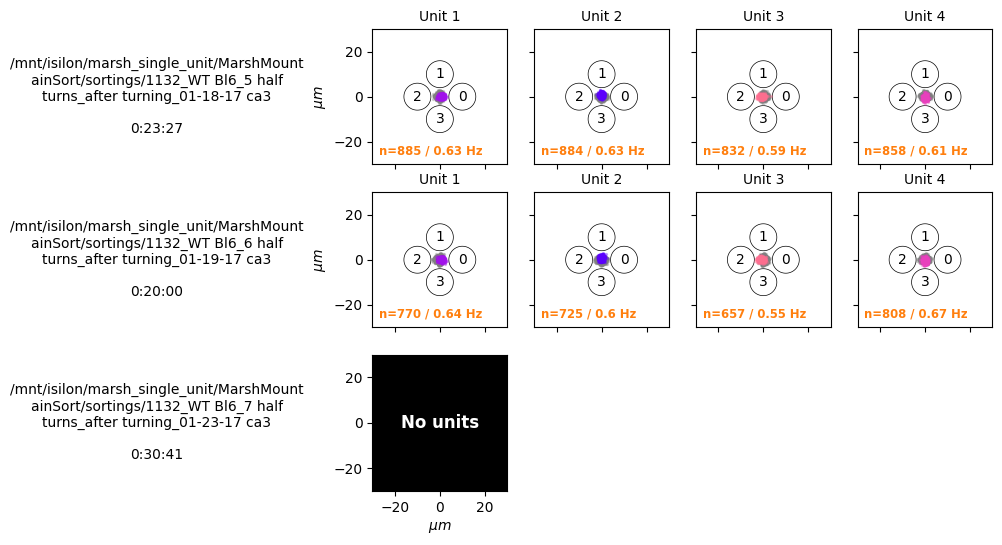

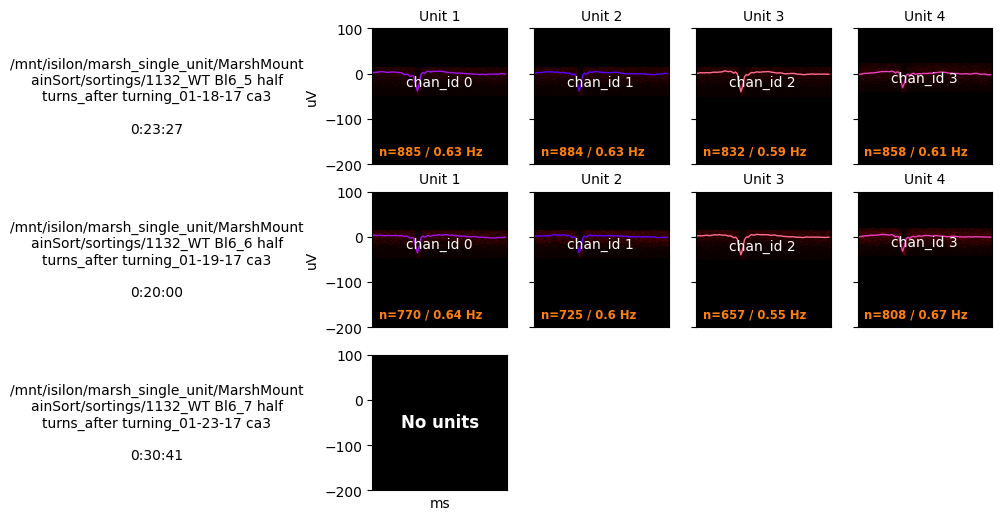

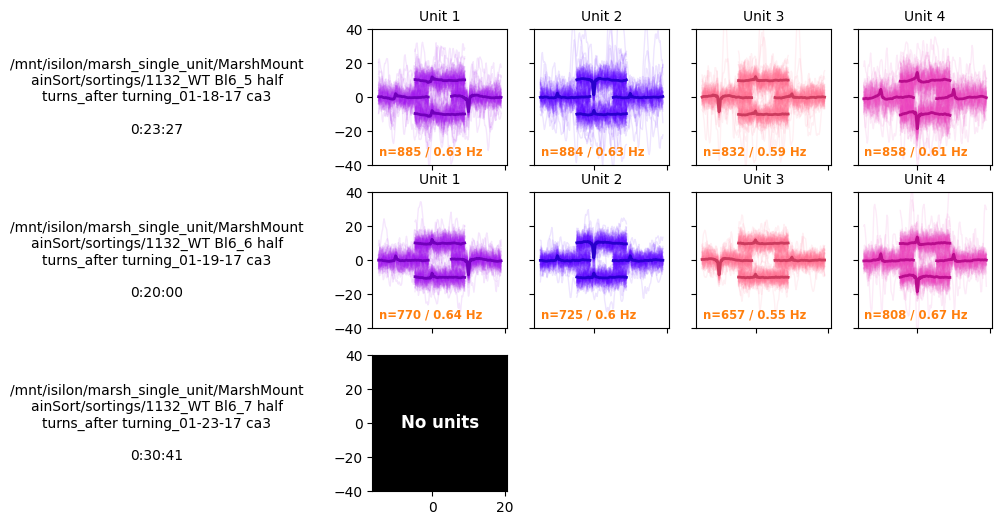

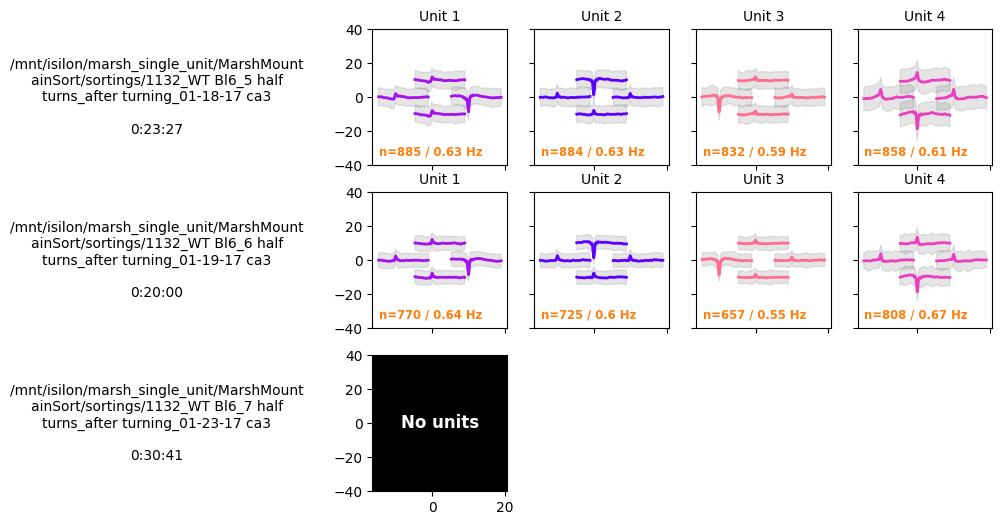

In [42]:
# %%script true
asl.plot_units_oneregion(region=region, xybound_location=(-30, 30), 
                         plot_type='location')
asl.plot_units_oneregion(region=region, ybound_heatmap=(-200, 100),
                         plot_type='heatmap')
asl.plot_units_oneregion(region=region, ybound_wavetemp=(-40, 40),
                         plot_type='waveform')
asl.plot_units_oneregion(region=region, ybound_wavetemp=(-40, 40),
                         plot_type='template')


In [43]:
%%script true
# 1211, 766
for ident in [501, 502, 513, 514, 529, 530, 537]:
    asl = AnimalSortLoader('/mnt/isilon/marsh_single_unit/MarshMountainSort/', identifier=ident)
    regions = ['ca3', 'ca3o', 'ca1s', 'ca1o']

    for region in regions:

        asl.load_sortings_df()
        asl.extract_analyzers_df()
        # temp = ap._get_computable_extensions(0)
        # for t in temp:
        #     print(f"{t} : {ap._get_default_extension_params(0, t)}")
        # break

        asl.compute_extension_df(extension='random_spikes', region=region, max_spikes_per_unit=1000)
        asl.compute_extension_df(extension='waveforms', region=region, ms_before=1.0, ms_after=2.0)
        asl.compute_extension_df(extension='templates', region=region, ms_before=1.0, ms_after=2.0)
        # asl.compute_extension_df(extension='principal_components', region=region)
        # asl.compute_extension_df(extension='spike_locations', region=region, ms_before=1.0, ms_after=2.0, method='monopolar_triangulation')
        asl.compute_extension_df(extension='spike_locations', region=region, ms_before=0.5, ms_after=0.5, method='center_of_mass')


        # asl.plot_units_oneregion(region=region, ybound_heatmap=(-200, 100), max_cols=10)
        tempsavepath = asl.base_folder / 'output-depthsort' / 'New Anims 12-2-24'
        asl.plot_units_oneregion(region=region, xybound_location=(-30, 30), 
                                plot_type='location', save_path=tempsavepath / f'{asl.identifier}_{region}_location')
        asl.plot_units_oneregion(region=region, ybound_heatmap=(-200, 100),
                                plot_type='heatmap', save_path=tempsavepath / f'{asl.identifier}_{region}_heatmap')
        asl.plot_units_oneregion(region=region, ybound_wavetemp=(-40, 40),
                                plot_type='waveform', save_path=tempsavepath / f'{asl.identifier}_{region}_waveform')
        asl.plot_units_oneregion(region=region, ybound_wavetemp=(-40, 40),
                                plot_type='template', save_path=tempsavepath / f'{asl.identifier}_{region}_template')

        break
    break


In [44]:
# temp = LongPyEEGReader('/mnt/isilon/marsh_single_unit/MarshMountainSort/pyeegbins/1133_WT_5 half turns_after recovery_01-25-17')
# rec: si.BaseRecording = temp.load_region('ca3')
# temp2 = LongIntanReader('/mnt/isilon/marsh_single_unit/MarshMountainSort/rhds/537-WT-M-5htL-5htR tetrodes 11-11-24_241111_105746')
# rec2: si.BaseRecording = temp2.load_region('ca1o')


In [45]:
# %%script true
# print(rec.get_channel_gains())
# print(rec.get_channel_offsets())
# print(rec2.get_channel_gains())
# print(rec2.get_channel_offsets())

# # print(temp.pyeeg_metadata.mult_to_uV)
# # traces = rec.get_traces(end_frame=25000 * 600)
# # print(np.min(traces))
# # print(np.max(traces))

# # traces = rec.get_traces(end_frame=25000 * 600, return_scaled=True)
# # print(np.min(traces))
# # print(np.max(traces))

# print("\nground truth:")
# traces2 = rec2.get_traces()
# print(np.min(traces2))
# print(np.max(traces2))

# # print(temp2.metadata)